<a href="https://colab.research.google.com/github/choderalab/gimlet/blob/master/lime/scripts/190819_yuanqing_gn_analyze_on_esol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep

In [0]:
! wget https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/ESOL.zip
! unzip *.zip
! pip install tensorflow==2.0.0-beta1
! pip uninstall gin-config -y
! rm -rf gimlet
! git clone https://github.com/choderalab/gimlet.git





'''
ds_all = gin.probabilistic.gn.GraphNet.batch(ds_all, 128).cache(
    str(os.getcwd()) + '/tmp')
ds_all = ds_all.shuffle(n_samples)
n_batched_samples_total = gin.probabilistic.gn.GraphNet.get_number_batches(
    ds_all)
n_batched_samples_total = int(n_batched_samples_total)
'''

--2019-08-20 17:19:02--  https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/ESOL.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.235.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.235.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32317 (32K) [application/zip]
Saving to: ‘ESOL.zip.1’

ESOL.zip.1          100%[===================>]  31.56K  --.-KB/s    in 0.02s   

2019-08-20 17:19:02 (1.35 MB/s) - ‘ESOL.zip.1’ saved [32317/32317]

Archive:  ESOL.zip
replace delaney-processed.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: tensorflow==2.0.0-beta1 in /usr/local/lib/python3.6/dist-packages (2.0.0b1)
Cloning into 'gimlet'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 1907 (delta 160), reused 139 (delta 65), pack-reused 1664
Receiving objects: 

"\nds_all = gin.probabilistic.gn.GraphNet.batch(ds_all, 128).cache(\n    str(os.getcwd()) + '/tmp')\nds_all = ds_all.shuffle(n_samples)\nn_batched_samples_total = gin.probabilistic.gn.GraphNet.get_number_batches(\n    ds_all)\nn_batched_samples_total = int(n_batched_samples_total)\n"

In [0]:
import os
import sys
import tensorflow as tf
sys.path.append('/content/gimlet')
import gin
import lime
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('delaney-processed.csv')
df = df[~df['smiles'].str.contains('B')]
df = df[~df['smiles'].str.contains('\%')]
df = df[~df['smiles'].str.contains('\.')]
df = df[~df['smiles'].str.contains('Se')]
df = df[~df['smiles'].str.contains('Si')]
df = df[~df['smiles'].str.contains('S@@')]
df = df[~df['smiles'].str.contains('6')]
df = df[~df['smiles'].str.contains('7')]
df = df[~df['smiles'].str.contains('8')]
df = df[~df['smiles'].str.contains('9')]
df = df[~df['smiles'].str.contains('\+')]
df = df[~df['smiles'].str.contains('\-')]
df = df[df['smiles'].str.len() > 1]
x_array = df[['smiles']].values.flatten()
y_array = df[['measured log solubility in mols per litre']].values.flatten()
y_array = (y_array - np.mean(y_array) / np.std(y_array))
n_samples = y_array.shape[0]
ds_all = gin.i_o.from_smiles.to_mols_with_attributes(x_array, y_array)

In [0]:
point = {
    'D_V': 32,
    'D_E': 32,
    'D_U': 64,

    'd_sigma_units': 16,
    'd_pi_units': 16,

    'phi_v_units': 64,
    'phi_v_activation': 'sigmoid',

    'phi_e_units': 32,
    'phi_e_activation': 'leaky_relu',

    'phi_u_units': 32,
    'phi_u_activation': 'tanh',

    'f_r_units': 64,

    'learning_rate': 1e-3
}

def init(point):
    global gn
    global optimizer

    class f_v(tf.keras.Model):
        """ Featurization of nodes.
        Here we simply featurize atoms using one-hot encoding.
        """
        def __init__(self, units=point['D_V']):
            super(f_v, self).__init__()
            self.d = tf.keras.layers.Dense(units)

        @tf.function
        def call(self, x):
            x = tf.one_hot(x, 8)
            # set shape because Dense doesn't like variation
            x.set_shape([None, 8])
            return self.d(x)

    class f_e(tf.keras.Model):
        """ Featurization of edges.
        Here we split the $\sigma$ and $\pi$ component of bonds
        into two channels, and featurize them seperately.
        """
        def __init__(
                self,
                d_sigma_units=point['d_sigma_units'],
                d_pi_units=point['d_pi_units'],
                D_E=point['D_E']):

            super(f_e, self).__init__()
            self.D_E = D_E

            # sigma
            self.d_sigma_0 = tf.Variable(
                tf.zeros(
                    shape=(1, d_sigma_units),
                    dtype=tf.float32))
            self.d_sigma_1 = tf.keras.layers.Dense(
                int(self.D_E // 2))

            # pi
            self.d_pi_0 = tf.keras.layers.Dense(
                d_pi_units)
            self.d_pi_1 = tf.keras.layers.Dense(
                int(self.D_E // 2))

        @tf.function
        def call(self, x):
            # determine whether there is $\pi$ component in the bond
            has_pi = tf.greater(
                x,
                tf.constant(1, dtype=tf.float32))

            # calculate the sigma component of the bond
            x_sigma = tf.tile(
                self.d_sigma_1(self.d_sigma_0),
                [tf.shape(x, tf.int64)[0], 1])

            # calculate the pi component of the bond
            x_pi = tf.where(
                has_pi,

                # if has pi:
                self.d_pi_1(
                    self.d_pi_0(
                        tf.math.subtract(
                            x,
                            tf.constant(1, dtype=tf.float32)))),

                # else:
                tf.zeros(
                    shape=(self.D_E // 2, ),
                    dtype=tf.float32))

            x = tf.concat(
                [
                    x_sigma,
                    x_pi
                ],
                axis=1)

            return x

    f_u=(lambda atoms, adjacency_map, batched_attr_mask: \
        tf.tile(
            tf.zeros((1, point['D_U'])),
            [
                 tf.math.count_nonzero(
                     tf.reduce_any(
                         batched_attr_mask,
                         axis=0)),
                 1
            ]
        ))

    phi_v = lime.nets.for_gn.ConcatenateThenFullyConnect(
        (
            point['phi_v_units'],
            point['phi_v_activation'],
            point['phi_v_units'],
            point['D_V']
        ))


    phi_e = lime.nets.for_gn.ConcatenateThenFullyConnect(
        (
            point['phi_e_units'],
            point['phi_e_activation'],
            point['phi_e_units'],
            point['D_E']
        ))

    class phi_u(tf.keras.Model):
        def __init__(self, config=(
                    point['phi_u_units'],
                    point['phi_u_activation'],
                    point['phi_u_units'],
                    point['D_U']
                )):
            super(phi_u, self).__init__()
            self.d = lime.nets.for_gn.ConcatenateThenFullyConnect(config)

        @tf.function
        def call(self, h_u, h_u_0, h_e_bar, h_v_bar):
            return self.d(h_u, h_u_0, h_e_bar, h_v_bar)


    class f_r(tf.keras.Model):
        """ Readout function.
        """

        def __init__(self, units=point['f_r_units']):
            super(f_r, self).__init__()
            self.d_e_0 = tf.keras.layers.Dense(units)
            self.d_s_0 = tf.keras.layers.Dense(units)
            self.d_e_1 = tf.keras.layers.Dense(1)
            self.d_s_1 = tf.keras.layers.Dense(1)

        @tf.function
        def call(self,
                h_e, h_v, h_u,
                h_e_history, h_v_history, h_u_history,
                atom_in_mol, bond_in_mol):

            # although this could take many many arguments,
            # we only take $h_e$ for now
            e = self.d_e_1(self.d_e_0(h_v))
            s = self.d_s_1(self.d_s_0(h_v))

            return e, s

    gn = gin.probabilistic.gn.GraphNet(
        f_e=f_e(),
        f_v=f_v(),
        f_u=f_u,
        phi_e=phi_e,
        phi_v=phi_v,
        phi_u=phi_u(),
        f_r=f_r(),
        repeat=5)

    optimizer = tf.keras.optimizers.Adam(point['learning_rate'])

init(point)

gn.load_weights('/content/gimlet/lime/scripts/partial_charge/partial_charge_weights')

# inspect

In [0]:
class f_r_new(tf.keras.Model):
    """ Readout function.
    """

    def __init__(self, units=point['f_r_units']):
        super(f_r_new, self).__init__()


    @tf.function
    def call(self,
            h_e, h_v, h_u,
            h_e_history, h_v_history, h_u_history,
            atom_in_mol, bond_in_mol):

        return h_v_history

In [0]:
gn.f_r = f_r_new()

In [0]:
h_v_history_all = -1 * tf.ones((1, 6, 32), dtype=tf.float32)
element_all = tf.constant([-1], dtype=tf.int64)
hybridization_all = tf.constant([-1], dtype=tf.int64)
aromatic_all = tf.constant([-1], dtype=tf.int64)

In [0]:
for atoms, adjacency_map, attr in ds_all:
    h_v_history = gn(atoms, adjacency_map)
    h_v_history_all = tf.concat(
        [
            h_v_history_all,
            h_v_history
        ],
        axis=0)
    
    
    typing = gin.deterministic.typing.Typing([atoms, adjacency_map])
    
    hybridization = tf.where(
        typing.is_sp1,
        tf.constant(1, dtype=tf.int64),
        tf.where(
            typing.is_sp2,
            tf.constant(2, dtype=tf.int64),
            tf.constant(3, dtype=tf.int64)))
    
    hybridization_all = tf.concat(
        [
            hybridization_all,
            hybridization
        ],
        axis=0)
    
    aromatic = tf.where(
        typing.is_aromatic,
        tf.constant(1, dtype=tf.int64),
        tf.constant(0, dtype=tf.int64))
    
    aromatic_all = tf.concat(
        [
            aromatic_all,
            aromatic
        ],
        axis=0)
    
    element_all = tf.concat(
        [
            element_all,
            atoms
        ],
        axis=0)
    

W0820 18:50:17.072694 139669472003840 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0820 18:50:17.109291 139669472003840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 18:50:23.387073 139669480396544 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0820 18:50:25.399045 139669472003840 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0820 18:50:27.179351 139669472003840 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0820 18:50:30.070906 139669472003840 backprop.py:842] The dtype of the watched ten

In [0]:
init(point)

gn.load_weights('/content/gimlet/lime/scripts/partial_charge/partial_charge_weights')

In [0]:
e_all = tf.constant([-1], dtype=tf.float32)
s_all = tf.constant([-1], dtype=tf.float32)

In [0]:
for atoms, adjacency_map, attr in ds_all:
    e, s = gn(atoms, adjacency_map)
    e_all = tf.concat([e_all, tf.reshape(e, [-1])], axis=0)
    s_all = tf.concat([s_all, tf.reshape(s, [-1])], axis=0)

In [0]:
e_all = e_all[1:]
s_all = s_all[1:]

In [0]:
from sklearn import decomposition

In [0]:
TRANSLATION = {
    0: 'C',
    1: 'N',
    2: 'O',
    3: 'S',
    4: 'P',
    5: 'F',
    6: 'Cl',
    7: 'Br',
    8: 'I',
    9: 'H'
}

In [0]:
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [0]:
h_v_history_all.shape

TensorShape([14261, 6, 32])

In [0]:
hybridization_all

<tf.Tensor: id=13392001, shape=(14261,), dtype=int64, numpy=array([-1,  3,  3, ...,  2,  2,  3])>

W0820 19:02:54.023674 139670501943168 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
W0820 19:02:54.071253 139670501943168 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

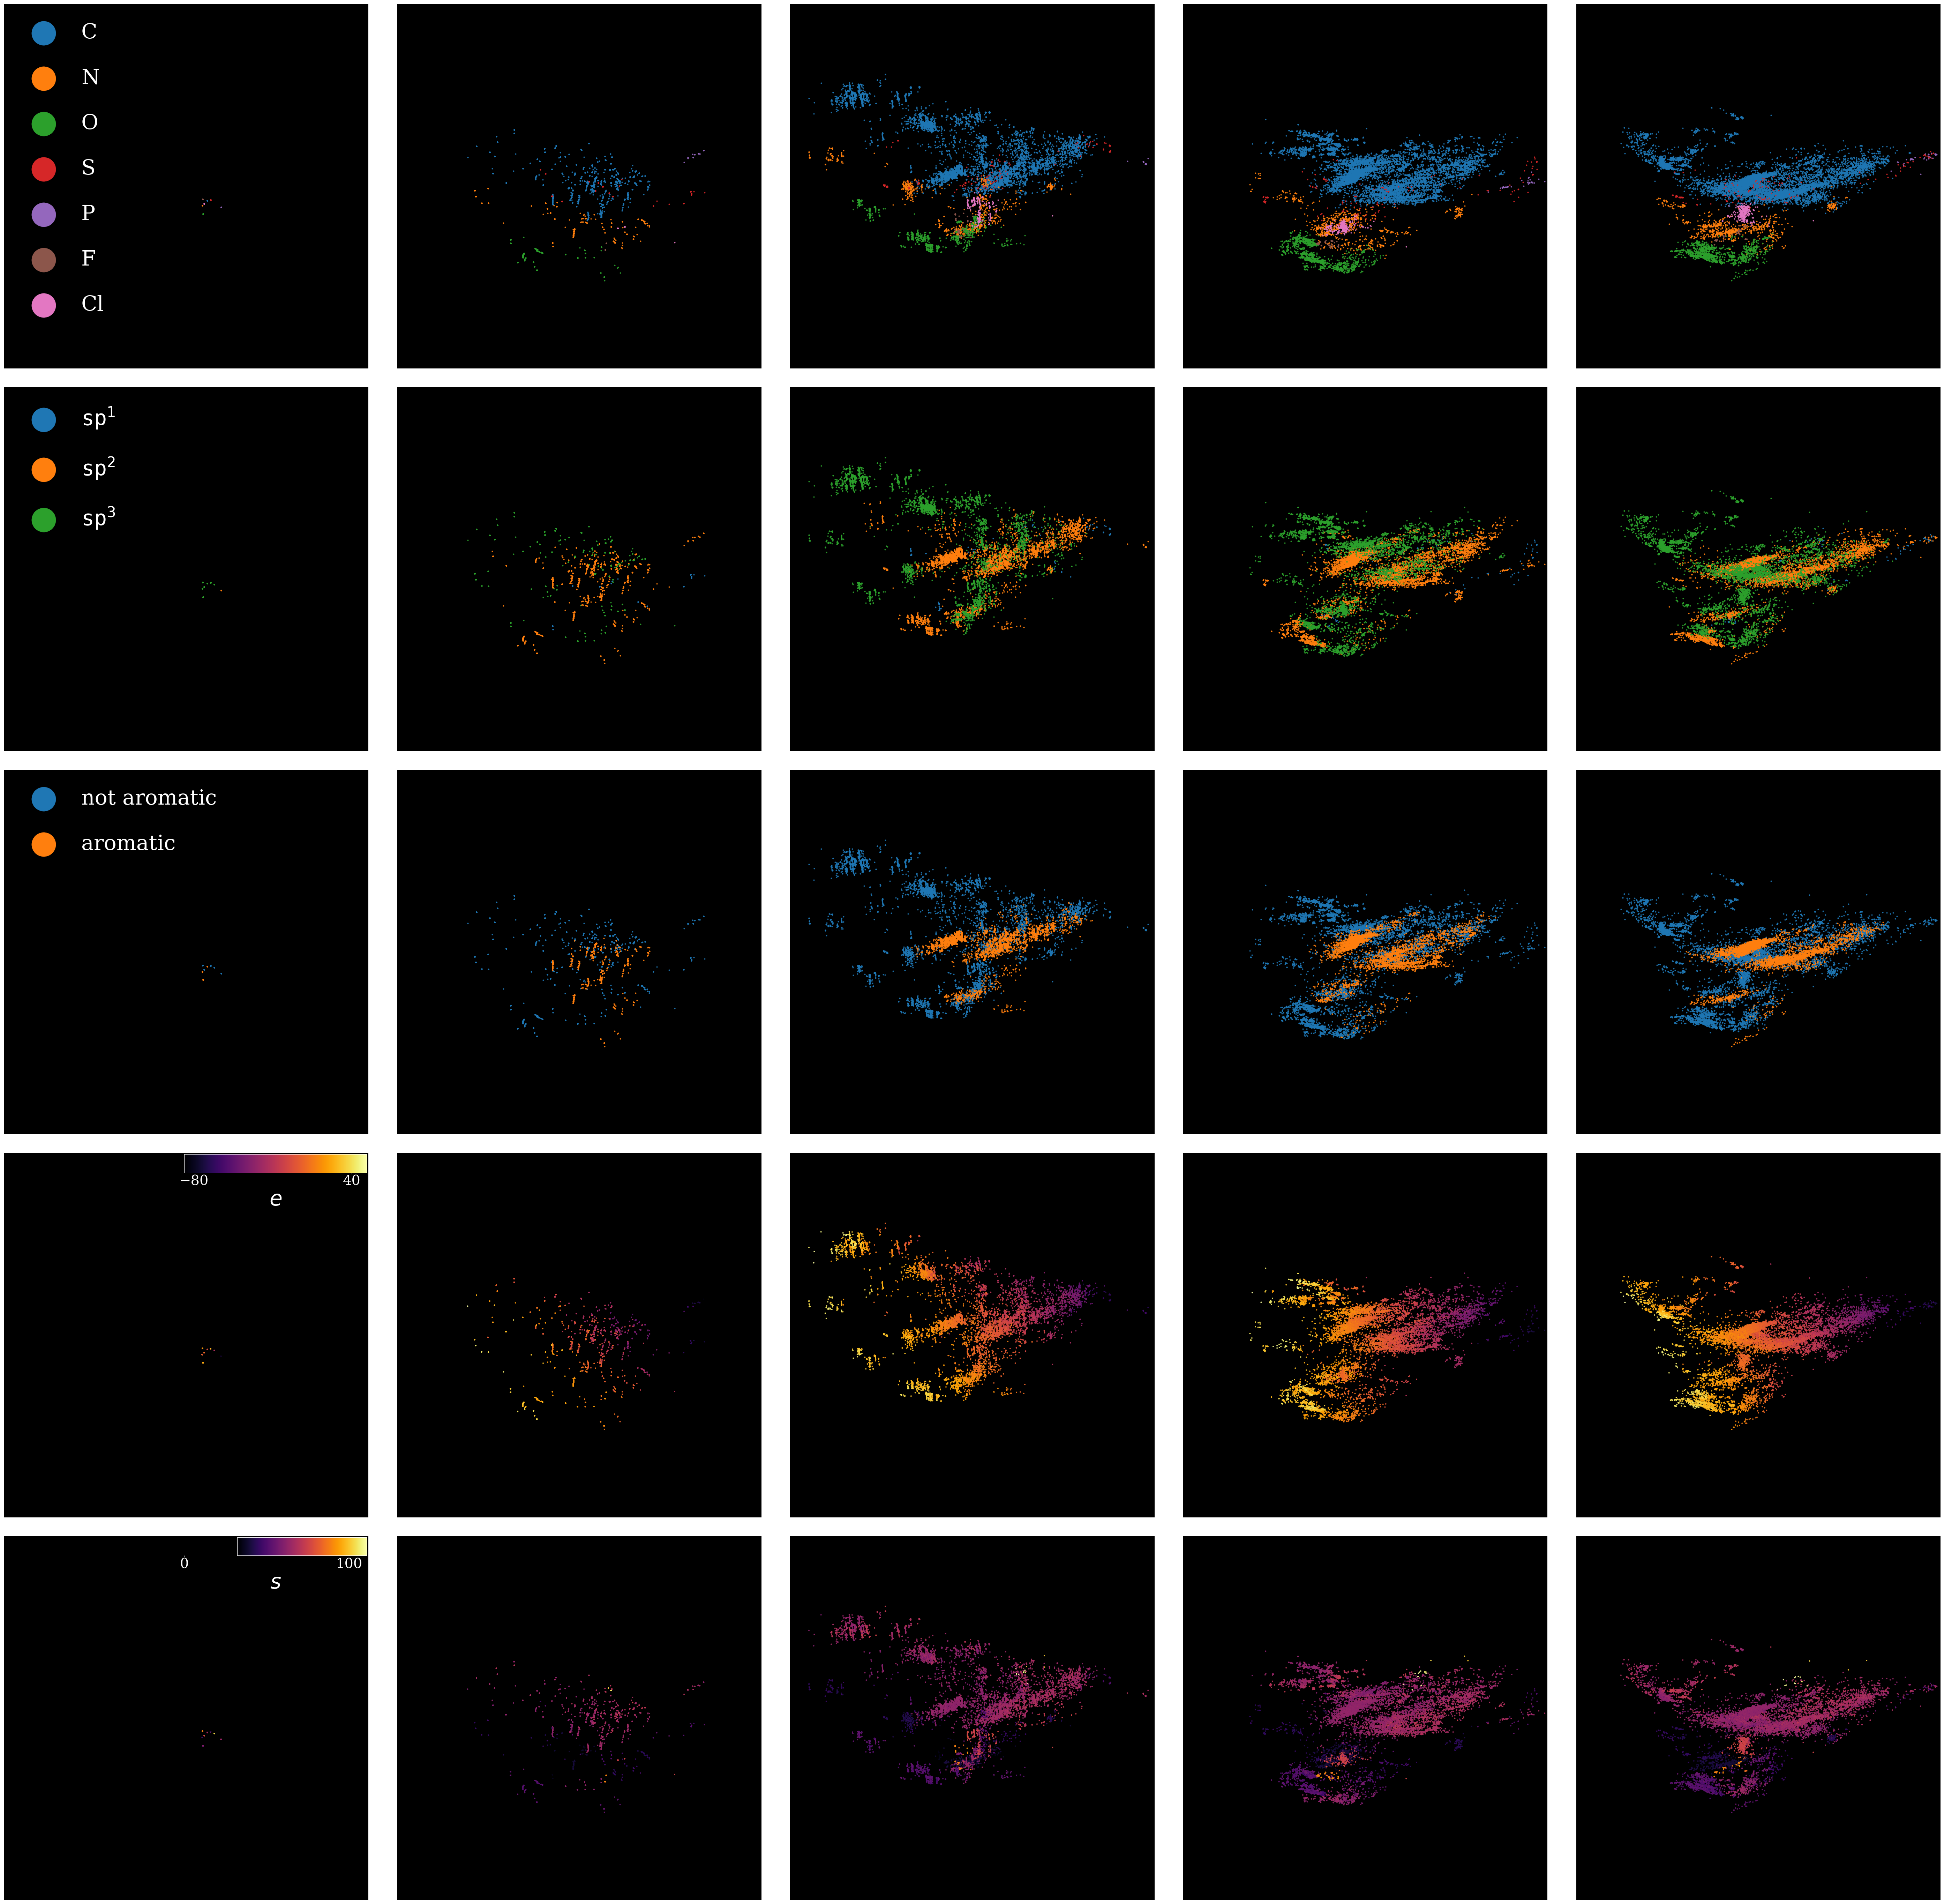

In [0]:
fig = plt.figure(figsize=(100, 100))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.style.use('ggplot')
plt.rc('font', family='serif')
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(5, 5)
gs.update(wspace=0.05, hspace=0.05)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


pca = decomposition.PCA(n_components=2)

pca.fit(h_v_history_all[1:, -1, :])


color_dict = matplotlib.cm.get_cmap('tab10').colors

for time_idx in range(5):
    for element_idx in list(range(7)):
        _mask = tf.equal(
            element_all, 
            tf.constant(element_idx, tf.int64))
        
        ax = fig.add_subplot(gs[time_idx], aspect='equal')

        __history = h_v_history_all[:, time_idx, :]
        
        _history = tf.boolean_mask(
            __history,
            _mask)

        h_v_pca = pca.transform(_history)

        _hybridization = tf.boolean_mask(
            hybridization_all,
            _mask)

        _aromatic = tf.boolean_mask(
            aromatic_all,
            _mask)

        ax.scatter(
            h_v_pca[:, 0],
            h_v_pca[:, 1],
            c=color_dict[element_idx],
            label=TRANSLATION[element_idx],
            cmap='tab10',
            s=12,
            alpha=0.95)

        ax.set_xlim((-15, 15))
        ax.set_ylim((-15, 15))

        ax.grid(False)
        ax.set_facecolor('black')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
       
    
    if time_idx == 0:
        leg = ax.legend(fontsize=60, markerscale=20, labelspacing=1.2,
        framealpha=0, loc='upper left')
        
        for l in leg.legendHandles:
            l.set_alpha(1)
            
            
        for text in leg.get_texts():
            text.set_color("white")

for time_idx in range(5):
    ax = fig.add_subplot(gs[time_idx+5], aspect='equal')
    __history = h_v_history_all[:, time_idx, :]
    h_v_pca = pca.transform(_history)
    
    for hybridization_idx in range(3):
        _mask = tf.equal(
            hybridization_all, 
            tf.constant(hybridization_idx+1, tf.int64))
        
        _history = tf.boolean_mask(
            __history,
            _mask)

        h_v_pca = pca.transform(_history)
        
        ax.scatter(
            h_v_pca[:, 0],
            h_v_pca[:, 1],
            c=color_dict[hybridization_idx],
            label=['$\mathtt{sp}^1$', '$\mathtt{sp}^2$', '$\mathtt{sp}^3$'][hybridization_idx],
            s=12,
            alpha=0.95)

        ax.set_xlim((-15, 15))
        ax.set_ylim((-15, 15))

        ax.grid(False)
        ax.set_facecolor('black')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    
    if time_idx == 0:
        leg = ax.legend(fontsize=60, markerscale=20, labelspacing=1.2,
        framealpha=0, loc='upper left')
        
        for l in leg.legendHandles:
            l.set_alpha(1)
            
            
        for text in leg.get_texts():
            text.set_color("white")
        
        
for time_idx in range(5):
    ax = fig.add_subplot(gs[time_idx+10], aspect='equal')
    __history = h_v_history_all[:, time_idx, :]
    h_v_pca = pca.transform(_history)
    
    for aromatic_idx in range(2):
        _mask = tf.equal(
            aromatic_all, 
            tf.constant(aromatic_idx, tf.int64))
        
        _history = tf.boolean_mask(
            __history,
            _mask)

        h_v_pca = pca.transform(_history)
        
        ax.scatter(
            h_v_pca[:, 0],
            h_v_pca[:, 1],
            c=color_dict[aromatic_idx],
            label=['not aromatic', 'aromatic'][aromatic_idx],
            s=12,
            alpha=0.95,
            cmap='inferno')

        ax.set_xlim((-15, 15))
        ax.set_ylim((-15, 15))

        ax.grid(False)
        ax.set_facecolor('black')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    
    if time_idx == 0:
        leg = ax.legend(fontsize=60, markerscale=20, labelspacing=1.2,
        framealpha=0, loc='upper left')
        
        for l in leg.legendHandles:
            l.set_alpha(1)
            
            
        for text in leg.get_texts():
            text.set_color("white")
         
        
for time_idx in range(5):
    ax = fig.add_subplot(gs[time_idx+15], aspect='equal')
    __history = h_v_history_all[1:, time_idx, :]
    h_v_pca = pca.transform(__history)
    
    norm = matplotlib.colors.Normalize(
        vmin=e_all.numpy().min(),
        vmax=e_all.numpy().max())
    
    ax.scatter(
        h_v_pca[:, 0],
        h_v_pca[:, 1],
        c=e_all,
        s=12,
        alpha=0.95,
        cmap='inferno',
        norm=norm)
    
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))

    ax.grid(False)
    ax.set_facecolor('black')

    ax.set_xticks([])
    ax.set_yticks([])
    
    
    if time_idx == 0:
        axins = inset_axes(ax,
                            width="50%",  # width = 50% of parent_bbox width
                            height="5%",  # height : 5%
                            loc='upper right')

        sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
        sm.set_array([])

        plt.colorbar(sm, cax=axins, orientation='horizontal')

        axins.xaxis.set_ticks((-80, 40))
        axins.set_xlabel('$e$', fontsize=60)
        axins.xaxis.label.set_color('white')
        
        axins.tick_params(axis='both', which='major', labelsize=40, colors='white')
    
    
for time_idx in range(5):
    ax = fig.add_subplot(gs[time_idx+20], aspect='equal')
    __history = h_v_history_all[1:, time_idx, :]
    h_v_pca = pca.transform(__history)
    
    norm = matplotlib.colors.Normalize(
        vmin=s_all.numpy().min(),
        vmax=s_all.numpy().max())
    
    ax.scatter(
        h_v_pca[:, 0],
        h_v_pca[:, 1],
        c=s_all,
        s=12,
        alpha=0.95,
        cmap='inferno',
        norm=norm)
    
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))

    ax.grid(False)
    ax.set_facecolor('black')

    ax.set_xticks([])
    ax.set_yticks([])
    
    if time_idx == 0:
        axins = inset_axes(ax,
                            width="50%",  # width = 50% of parent_bbox width
                            height="5%",  # height : 5%
                            loc='upper right')

        sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
        sm.set_array([])

        plt.colorbar(sm, cax=axins, orientation='horizontal')

        axins.xaxis.set_ticks((0, 100))
        axins.set_xlabel('$s$', fontsize=60)
        axins.xaxis.label.set_color('white')
        axins.tick_params(axis='both', which='major', labelsize=40, colors='white')
        

In [0]:
xs = tf.reshape(
    tf.math.divide(
        tf.range(0, 3000, dtype=tf.float32),
        tf.constant(1000, dtype=tf.float32)),
    [3000, 1])

In [0]:
ys = gn.f_e(xs)

Text(0, 0.5, 'bond order')

<Figure size 1440x1440 with 0 Axes>

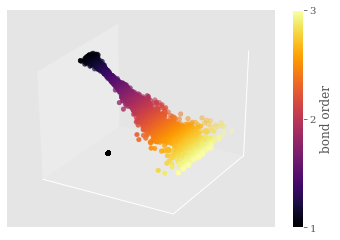

In [0]:
fig = plt.figure(figsize=(20, 20))

plt.style.use('ggplot')
plt.rc('font', family='serif')

pca = decomposition.PCA(n_components=3)
ys = pca.fit_transform(ys)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

norm = matplotlib.colors.Normalize(
    vmin=1,
    vmax=3)


sc = ax.scatter(ys[:, 0], ys[:, 2], ys[:, 1], c=xs.numpy().flatten(), cmap='inferno', norm=norm)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# ax.axis('off')
# ax.grid(False)
cbar = fig.colorbar(sc)
cbar.set_ticks((1, 2, 3))
cbar.ax.set_ylabel('bond order')

In [0]:
fig.savefig('temp.png', transparent=True, dpi=100)

In [0]:
for atoms, adjacency_map, attr in ds_all:

    with tf.GradientTape() as tape:
        e, s = gn(atoms, adjacency_map)
        

    print(tape.gradient(s, atoms))
    
    break


    

W0820 19:49:57.890862 139670501943168 backprop.py:990] The dtype of the source tensor must be floating (e.g. tf.float32) when calling GradientTape.gradient, got tf.int64


None
